Using device: cuda
Backbone: convnextv2_tiny.fcmae_ft_in1k
Total params: 28,583,071 | Trainable: 28,583,071

Starting Training with MixUp/CutMix...
Epoch 1/25 | Train Loss 1.9492 | Val Acc 70.46% | LR 0.000100 | 76.8s
>>> Saved new best model!
Epoch 2/25 | Train Loss 1.6993 | Val Acc 79.95% | LR 0.000098 | 75.1s
>>> Saved new best model!
Epoch 3/25 | Train Loss 1.5994 | Val Acc 84.96% | LR 0.000096 | 75.0s
>>> Saved new best model!
Epoch 4/25 | Train Loss 1.5281 | Val Acc 86.86% | LR 0.000094 | 74.3s
>>> Saved new best model!
Epoch 5/25 | Train Loss 1.4887 | Val Acc 89.37% | LR 0.000090 | 74.4s
>>> Saved new best model!
Epoch 6/25 | Train Loss 1.4359 | Val Acc 89.90% | LR 0.000086 | 74.5s
>>> Saved new best model!
Epoch 7/25 | Train Loss 1.3832 | Val Acc 91.02% | LR 0.000082 | 76.3s
>>> Saved new best model!
Epoch 8/25 | Train Loss 1.3576 | Val Acc 91.32% | LR 0.000077 | 74.3s
>>> Saved new best model!
Epoch 9/25 | Train Loss 1.3242 | Val Acc 92.64% | LR 0.000071 | 76.8s
>>> Saved new 

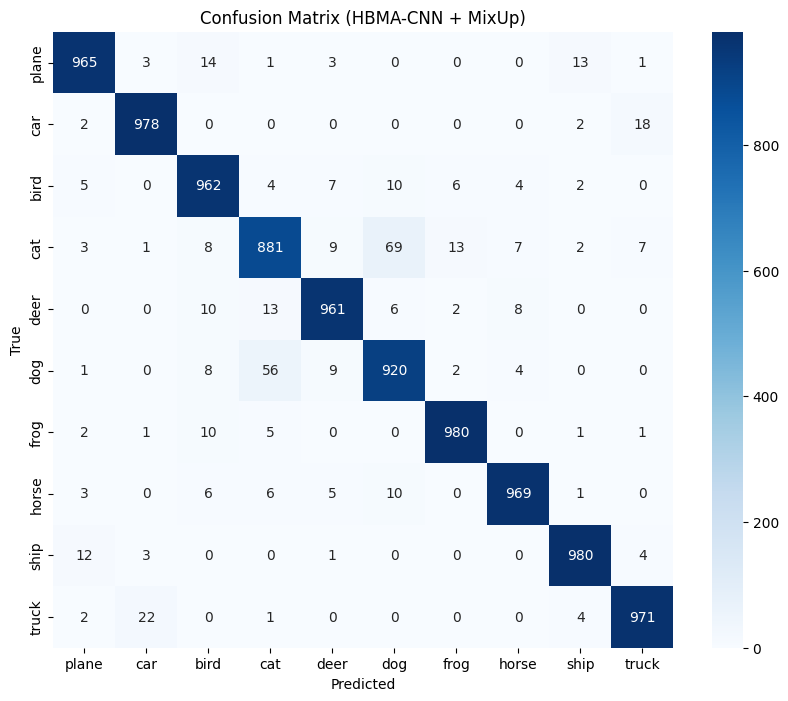

In [2]:
# =======================================================
# hybrid_conv_derivative_frontend.ipynb
# =======================================================
# A hybrid CNN for CIFAR-10 featuring:
# 1. Adaptive Bio-Inspired Front-End (Retinal Derivatives)
# 2. ConvNeXt Backbone (Architectural Modernization)
# 3. SE-Attention (Efficiency Optimization)
# 4. Higher-Order Enhancer (Mathematical Stability)
# 5. MixUp & CutMix Regularization (Robustness & Generalization)
# =======================================================

import os
import time
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets
import timm
from timm.data.mixup import Mixup
from timm.loss import SoftTargetCrossEntropy
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# =======================================================
# Basic setup: device, training hyperparameters, etc.
# =======================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
EPOCHS = 25  # As MixUp requires more epochs to converge
LR = 1e-4
NUM_CLASSES = 10
WORKERS = min(4, (os.cpu_count() or 2))
PATIENCE = 7 # Increased patience for MixUp
WEIGHT_DECAY = 1e-4

# =======================================================
# Data augmentation pipeline
# =======================================================
class AddGaussianNoise:
    """Adds random Gaussian noise to images for robustness."""
    def __init__(self, mean=0., std=0.05, p=0.3):
        self.mean = mean
        self.std = std
        self.p = p

    def __call__(self, img):
        if torch.rand(1).item() < self.p:
            return img + torch.randn_like(img) * self.std + self.mean
        return img

# Compose the training transforms
# Note: We removed aggressive GaussianBlur here because CutMix provides better regularization
train_aug = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(64, padding=8),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    AddGaussianNoise(std=0.05, p=0.3),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616)),
])

# Compose the test transforms
test_aug = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616)),
])

# Load CIFAR-10 dataset
print("Downloading Datasets...")
train_set = datasets.CIFAR10("./data", train=True, download=True, transform=train_aug)
test_set = datasets.CIFAR10("./data", train=False, download=True, transform=test_aug)

train_loader = DataLoader(train_set, BATCH_SIZE, shuffle=True, num_workers=WORKERS, pin_memory=True)
test_loader = DataLoader(test_set, BATCH_SIZE, shuffle=False, num_workers=WORKERS, pin_memory=True)

# =======================================================
# Higher-order derivative filters
# =======================================================
def make_gaussian(ksize=7, sigma=1.0):
    """Generates a normalized 2D Gaussian kernel."""
    ax = np.arange(-(ksize//2), ksize//2 + 1, dtype=np.float32)
    xx, yy = np.meshgrid(ax, ax)
    g = np.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    g /= g.sum()
    return g

def make_gaussian_derivative_kernels(ksize=7, sigma=1.0,
                                     orders=((1,0),(0,1),(2,0),(0,2),(1,1))):
    """
    Generates a set of analytic derivative-of-Gaussian kernels.
    """
    ax = np.arange(-(ksize//2), ksize//2 + 1, dtype=np.float32)
    xx, yy = np.meshgrid(ax, ax)

    kernels = []
    G = np.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    G *= 1.0 / (2.0 * math.pi * sigma**2)

    for dx, dy in orders:
        if (dx, dy) == (1, 0):
            K = -xx / (sigma**2) * G
        elif (dx, dy) == (0, 1):
            K = -yy / (sigma**2) * G
        elif (dx, dy) == (2, 0):
            K = (xx**2 - sigma**2) / (sigma**4) * G
        elif (dx, dy) == (0, 2):
            K = (yy**2 - sigma**2) / (sigma**4) * G
        elif (dx, dy) == (1, 1):
            K = (xx * yy) / (sigma**4) * G
        else:
            K = G.copy()  # fallback
        K /= np.sum(np.abs(K))  # normalize
        kernels.append(K.astype(np.float32))
    return kernels

# =======================================================
# PreCortical front-end with derivative bank
# =======================================================
class PreCorticalFrontEnd(nn.Module):
    """
    Front-end module using analytic Gaussian derivatives.
    """
    def __init__(self, in_ch=3, out_ch=24,
                 derivative_ksize=7, derivative_sigma=1.0,
                 derivative_orders=((1,0),(0,1),(2,0),(0,2),(1,1)),
                 trainable_derivatives=False):
        super().__init__()

        self.in_ch = in_ch
        self.orders = derivative_orders
        self.n_kernels = len(self.orders)

        # build derivative convolution
        derivs = make_gaussian_derivative_kernels(ksize=derivative_ksize,
                                                  sigma=derivative_sigma,
                                                  orders=self.orders)
        out_ch_bank = in_ch * self.n_kernels
        self.deriv_conv = nn.Conv2d(in_ch, out_ch_bank,
                                    kernel_size=derivative_ksize,
                                    padding=derivative_ksize//2,
                                    bias=False)
        # initialize weights with analytic kernels
        with torch.no_grad():
            w = torch.zeros((out_ch_bank, in_ch, derivative_ksize, derivative_ksize), dtype=torch.float32)
            for in_c in range(in_ch):
                for j, K in enumerate(derivs):
                    out_idx = in_c * self.n_kernels + j
                    w[out_idx, in_c, :, :] = torch.from_numpy(K)
            self.deriv_conv.weight.copy_(w)

        # Make parameters trainable if requested (Adaptive Bio-Module)
        for p in self.deriv_conv.parameters():
            p.requires_grad = trainable_derivatives

        # small projection stack to reduce channel count
        self.stack = nn.Sequential(
            nn.Conv2d(out_ch_bank, out_ch, 3, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(out_ch),
            nn.Dropout2d(0.1),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(out_ch)
        )

    def forward(self, x):
        x = self.deriv_conv(x)
        # Local Contrast Normalization approximation
        mean_local = F.avg_pool2d(x, kernel_size=7, stride=1, padding=3)
        x = x - mean_local
        return self.stack(x)

# =======================================================
# Efficiency Module (Attention)
# =======================================================
class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation (SE) Block for Channel Attention.
    """
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.fc(x).view(b, c, 1, 1)
        return x * y

# =======================================================
# Higher-order feature enhancer
# =======================================================
class HigherOrderEnhancer(nn.Module):
    """
    Tracks feature statistics across mini-batches and boosts
    stable patterns using an exponential moving average.
    """
    def __init__(self, ch, a_now=0.7, a_prev=0.3, decay=0.85):
        super().__init__()
        self.a_now = a_now
        self.a_prev = a_prev
        self.decay = decay

        self.fuse = nn.Sequential(
            nn.Conv2d(ch, ch, 1),
            nn.ReLU(True),
            nn.BatchNorm2d(ch),
            nn.Dropout2d(0.1)
        )
        self.register_buffer("ema", torch.zeros(1, ch, 1, 1))

    def forward(self, x):
        with torch.no_grad():
            pooled = F.adaptive_avg_pool2d(x, 1).mean(0, keepdim=True)
            self.ema.mul_(self.decay).add_(pooled * (1 - self.decay))

        ema_feat = self.ema.expand(x.size(0), -1, x.size(2), x.size(3))
        out = self.a_now * x + self.a_prev * ema_feat
        return x + self.fuse(out)

# =======================================================
# Full Hybrid Model
# =======================================================
class HybridConvModel(nn.Module):
    """
    Combines derivative front-end, ConvNeXt backbone, SE Attention,
    and higher-order enhancer.
    """
    def __init__(self, classes=10, pretrained=True, dropout=0.3,
                 derivative_ksize=7, derivative_sigma=1.0, trainable_derivatives=True):
        super().__init__()

        # 1. Adaptive Bio-Module
        self.front = PreCorticalFrontEnd(3, 24,
                                         derivative_ksize=derivative_ksize,
                                         derivative_sigma=derivative_sigma,
                                         trainable_derivatives=trainable_derivatives)

        # 2. ConvNeXt Backbone
        backbone = None
        for name in ["convnextv2_tiny.fcmae_ft_in1k", "convnextv2_tiny", "convnextv2_atto"]:
            try:
                backbone = timm.create_model(name, pretrained=pretrained, num_classes=0,
                                             global_pool='', in_chans=24, drop_path_rate=0.1)
                self.backbone_name = name
                break
            except:
                continue
        if backbone is None:
            backbone = timm.create_model("convnext_tiny", pretrained=pretrained, num_classes=0, in_chans=24)
            self.backbone_name = "fallback_convnext"
        self.backbone = backbone

        # Determine output channels
        with torch.no_grad():
            dummy = torch.zeros(1, 24, 64, 64)
            ch = self.backbone.forward_features(dummy).shape[1]

        # 3. Efficiency Module (Attention)
        self.attention = SEBlock(ch, reduction=16)

        # 4. Stability Module (Higher Order)
        self.ho = HigherOrderEnhancer(ch)

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(ch, classes)

    def forward(self, x):
        x = self.front(x)                     # Bio-Front End
        x = self.backbone.forward_features(x) # ConvNeXt
        x = self.attention(x)                 # SE-Attention (Efficiency)
        x = self.ho(x)                        # Higher-Order (Stability)
        x = self.pool(x).flatten(1)
        x = self.drop(x)
        return self.fc(x)

# =======================================================
# Training & evaluation utilities
# =======================================================
def train_epoch(model, loader, opt, loss_fn, scaler=None, mixup_fn=None):
    model.train()
    total_loss, total_seen = 0.0, 0

    # We remove 'total_correct' from training log because MixUp labels are soft
    # and accuracy isn't well-defined for mixed images (e.g. 70% cat / 30% dog)

    for img, lbl in loader:
        img, lbl = img.to(DEVICE), lbl.to(DEVICE)

        # --- APPLY MIXUP / CUTMIX ---
        if mixup_fn is not None:
            img, lbl = mixup_fn(img, lbl)

        opt.zero_grad()

        if scaler:
            with torch.amp.autocast('cuda'):
                out = model(img)
                loss = loss_fn(out, lbl)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
        else:
            out = model(img)
            loss = loss_fn(out, lbl)
            loss.backward()
            opt.step()

        total_loss += loss.item() * img.size(0)
        total_seen += img.size(0)

    return total_loss / total_seen

def eval_epoch(model, loader, loss_fn):
    model.eval()
    total_loss, total_correct, total_seen = 0.0, 0, 0
    with torch.no_grad():
        for img, lbl in loader:
            img, lbl = img.to(DEVICE), lbl.to(DEVICE)
            out = model(img)
            loss = loss_fn(out, lbl)
            total_loss += loss.item() * img.size(0)
            total_correct += (out.argmax(1) == lbl).sum().item()
            total_seen += img.size(0)
    return total_loss / total_seen, total_correct / total_seen

def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

def plot_confusion_matrix(model, loader, classes):
    """Plots a confusion matrix for the test set."""
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for img, lbl in loader:
            img = img.to(DEVICE)
            outputs = model(img)
            _, preds = torch.max(outputs, 1)
            y_true.extend(lbl.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (HBMA-CNN + MixUp)')
    plt.show()

# =======================================================
# Main training and evaluation
# =======================================================
if __name__ == "__main__":
    print("Using device:", DEVICE)
    model = HybridConvModel(NUM_CLASSES, pretrained=True, dropout=0.3, trainable_derivatives=True).to(DEVICE)
    print("Backbone:", model.backbone_name)

    total_params, trainable_params = count_params(model)
    print(f"Total params: {total_params:,} | Trainable: {trainable_params:,}")

    # ===================================================
    # MIXUP CONFIGURATION
    # ===================================================
    mixup_fn = Mixup(
        mixup_alpha=0.8,       # Strength of mix (beta distribution)
        cutmix_alpha=1.0,      # Strength of cut (beta distribution)
        cutmix_minmax=None,
        prob=1.0,              # Probability of applying per batch
        switch_prob=0.5,       # 50/50 chance between MixUp and CutMix
        mode='batch',
        label_smoothing=0.1,   # Label smoothing is applied here!
        num_classes=NUM_CLASSES
    )

    optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

    # LOSS FUNCTIONS
    # 1. Training: Handles mixed targets + smoothing
    train_loss_fn = SoftTargetCrossEntropy()
    # 2. Validation: Standard CrossEntropy (clean targets)
    val_loss_fn = nn.CrossEntropyLoss()

    scaler = torch.amp.GradScaler('cuda') if torch.cuda.is_available() else None

    best_acc = 0.0
    wait = 0

    print("\nStarting Training with MixUp/CutMix...")
    for ep in range(EPOCHS):
        t0 = time.time()

        # Train with MixUp
        tr_loss = train_epoch(model, train_loader, optimizer, train_loss_fn, scaler, mixup_fn)

        # Validate (No MixUp)
        val_loss, val_acc = eval_epoch(model, test_loader, val_loss_fn)

        scheduler.step()
        t1 = time.time()

        print(f"Epoch {ep+1}/{EPOCHS} | Train Loss {tr_loss:.4f} | Val Acc {val_acc*100:.2f}% | LR {optimizer.param_groups[0]['lr']:.6f} | {t1-t0:.1f}s")

        if val_acc > best_acc:
            best_acc = val_acc
            wait = 0
            torch.save(model.state_dict(), "best_hybrid_model_robust.pth")
            print(">>> Saved new best model!")
        else:
            wait += 1

        if wait >= PATIENCE:
            print("Early stopping triggered.")
            break

    print(f"\nBest validation accuracy: {best_acc*100:.2f}%")

    # ------------------------------------------------------
    # Robustness evaluation
    # ------------------------------------------------------
    print("\nReloading best model for robustness testing...")
    model = HybridConvModel(NUM_CLASSES, pretrained=False, dropout=0.3, trainable_derivatives=True).to(DEVICE)
    model.load_state_dict(torch.load("best_hybrid_model_robust.pth", map_location=DEVICE))
    model.eval()

    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2470, 0.2435, 0.2616)

    clean_trans = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor(), transforms.Normalize(mean,std)])
    noise_trans = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor(),
                                      transforms.Lambda(lambda x: torch.clamp(x + 0.1*torch.randn_like(x), 0,1)),
                                      transforms.Normalize(mean,std)])
    blur_trans = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor(),
                                     transforms.GaussianBlur(5,sigma=1.5),
                                     transforms.Normalize(mean,std)])

    clean_set = datasets.CIFAR10("./data", train=False, download=True, transform=clean_trans)
    noise_set = datasets.CIFAR10("./data", train=False, download=False, transform=noise_trans)
    blur_set  = datasets.CIFAR10("./data", train=False, download=False, transform=blur_trans)

    clean_loader = DataLoader(clean_set, 128, shuffle=False)
    noise_loader = DataLoader(noise_set, 128, shuffle=False)
    blur_loader  = DataLoader(blur_set, 128, shuffle=False)

    def accuracy(model, loader):
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                out = model(x)
                correct += (out.argmax(1) == y).sum().item()
                total += y.size(0)
        return correct / total * 100

    clean_acc = accuracy(model, clean_loader)
    noise_acc = accuracy(model, noise_loader)
    blur_acc  = accuracy(model, blur_loader)

    print("\n================ CIFAR-10 Robustness Report ================")
    print(f"Clean Accuracy : {clean_acc:.2f}%")
    print(f"Noisy Accuracy : {noise_acc:.2f}%")
    print(f"Blur Accuracy  : {blur_acc:.2f}%")
    print("============================================================")

    # ------------------------------------------------------
    # Visualization: Confusion Matrix
    # ------------------------------------------------------
    print("\nGenerating Confusion Matrix...")
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    plot_confusion_matrix(model, clean_loader, classes)

In [ ]:
# ============================================================
# Transfer_Learning_Architecture_Comparison.py
# Comparing ConvNeXtV2, RetinaNet, and HigherOrderDiffCNN on CIFAR-10
# ============================================================

import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
import numpy as np

# ---------------------------
# Config
# ---------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
EPOCHS = 15
LR = 1e-4
NUM_CLASSES = 10
WORKERS = min(4, (os.cpu_count() or 2))
WEIGHT_DECAY = 1e-4
PATIENCE = 5

print(f"Device: {DEVICE}")
print(f"Batch Size: {BATCH_SIZE}, Epochs: {EPOCHS}")
print("="*60)

# ---------------------------
# Data Transforms
# ---------------------------
mean = (0.4914, 0.4822, 0.4465)
std = (0.2470, 0.2435, 0.2616)

transform_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(64, padding=8),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_test_clean = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_test_noise = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.clamp(x + 0.1 * torch.randn_like(x), 0, 1)),
    transforms.Normalize(mean, std),
])

transform_test_blur = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.GaussianBlur(5, sigma=1.5),
    transforms.Normalize(mean, std),
])

# ---------------------------
# Load Datasets
# ---------------------------
print("Loading CIFAR-10 dataset...")

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_clean = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test_clean)
test_noise = datasets.CIFAR10(root='./data', train=False, download=False, transform=transform_test_noise)
test_blur = datasets.CIFAR10(root='./data', train=False, download=False, transform=transform_test_blur)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS, pin_memory=True)
loader_clean = DataLoader(test_clean, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)
loader_noise = DataLoader(test_noise, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)
loader_blur = DataLoader(test_blur, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

print(f"Train samples: {len(train_set)}, Test samples: {len(test_clean)}")
print("="*60)



# =====================================================
# Architecture 1: ConvNeXtV2
# =====================================================
class ConvNeXtV2Model(nn.Module):
    def __init__(self, num_classes=10, pretrained=True):
        super().__init__()
        try:
            self.backbone = timm.create_model(
                'convnextv2_tiny.fcmae_ft_in1k',
                pretrained=pretrained,
                num_classes=num_classes,
                in_chans=3
            )
            self.name = "ConvNeXtV2-Tiny"
        except:
            self.backbone = timm.create_model(
                'convnext_tiny',
                pretrained=pretrained,
                num_classes=num_classes,
                in_chans=3
            )
            self.name = "ConvNeXt-Tiny (Fallback)"

    def forward(self, x):
        return self.backbone(x)



# =====================================================
# Architecture 2: RetinaNet (ResNet-based)
# =====================================================
class RetinaNetModel(nn.Module):
    def __init__(self, num_classes=10, pretrained=True):
        super().__init__()

        try:
            self.backbone = timm.create_model(
                'resnet50',
                pretrained=pretrained,
                num_classes=num_classes,
                in_chans=3
            )
            self.name = "RetinaNet-ResNet50"
        except:
            self.backbone = timm.create_model(
                'resnet34',
                pretrained=pretrained,
                num_classes=num_classes,
                in_chans=3
            )
            self.name = "RetinaNet-ResNet34 (Fallback)"

    def forward(self, x):
        return self.backbone(x)



# =====================================================
# Architecture 3: Higher-Order Differential CNN
# =====================================================
class HigherOrderDiffCNN(nn.Module):
    def __init__(self, num_classes=10, pretrained=True):
        super().__init__()
        self.name = "HigherOrderDiffCNN"

        # Correct fixed: Conv2D weight must be (out_channels, in_channels, k, k)
        self.derivative_layer = nn.Conv2d(3, 3, kernel_size=3, padding=1, bias=False)

        # Sobel X, Sobel Y, Laplacian
        sobel_x = torch.tensor([[-1, 0, 1],
                                [-2, 0, 2],
                                [-1, 0, 1]], dtype=torch.float32)

        sobel_y = torch.tensor([[-1, -2, -1],
                                [0, 0, 0],
                                [1, 2, 1]], dtype=torch.float32)

        laplacian = torch.tensor([[0, 1, 0],
                                  [1, -4, 1],
                                  [0, 1, 0]], dtype=torch.float32)

        # Expand each kernel to 3 input channels
        k1 = sobel_x.unsqueeze(0).repeat(3, 1, 1)
        k2 = sobel_y.unsqueeze(0).repeat(3, 1, 1)
        k3 = laplacian.unsqueeze(0).repeat(3, 1, 1)

        kernels = torch.stack([k1, k2, k3])  # Shape: [3, 3, 3, 3]

        with torch.no_grad():
            self.derivative_layer.weight.copy_(kernels)

        # Freeze derivative layer
        for p in self.derivative_layer.parameters():
            p.requires_grad = False

        # Pretrained ResNet18
        self.backbone = timm.create_model(
            'resnet18',
            pretrained=pretrained,
            num_classes=num_classes,
            in_chans=3
        )

        # Freeze backbone
        for p in self.backbone.parameters():
            p.requires_grad = False

        # Replace final FC layer for training
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, x):
        x = self.derivative_layer(x)
        return self.backbone(x)



# =====================================================
# Training & Evaluation Functions
# =====================================================
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    loss_sum = correct = total = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * imgs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += imgs.size(0)

    return loss_sum / total, correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    loss_sum = correct = total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            loss_sum += loss.item() * imgs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += imgs.size(0)

    return loss_sum / total, correct / total


def test_accuracy(model, loader, device):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total



# =====================================================
# Training Pipeline
# =====================================================
def train_model(model, model_name, train_loader, val_loader, device, epochs=EPOCHS):
    print(f"\nTraining {model_name}\n{'='*60}")

    model = model.to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

    best_acc = 0
    patience_counter = 0

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), f"best_{model_name}.pth")
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE:
            print("Early stopping triggered!")
            break

    model.load_state_dict(torch.load(f"best_{model_name}.pth"))
    return model, best_acc



# =====================================================
# Main Execution
# =====================================================
if __name__ == "__main__":
    results = {}

    # 1. ConvNeXtV2
    model1 = ConvNeXtV2Model(NUM_CLASSES, pretrained=True)
    model1, _ = train_model(model1, "ConvNeXtV2", train_loader, loader_clean, DEVICE)
    results["ConvNeXtV2"] = {
        "clean": test_accuracy(model1, loader_clean, DEVICE),
        "noise": test_accuracy(model1, loader_noise, DEVICE),
        "blur": test_accuracy(model1, loader_blur, DEVICE)
    }

    # 2. RetinaNet backbone
    model2 = RetinaNetModel(NUM_CLASSES, pretrained=True)
    model2, _ = train_model(model2, "RetinaNet", train_loader, loader_clean, DEVICE)
    results["RetinaNet"] = {
        "clean": test_accuracy(model2, loader_clean, DEVICE),
        "noise": test_accuracy(model2, loader_noise, DEVICE),
        "blur": test_accuracy(model2, loader_blur, DEVICE)
    }

    # 3. Higher-Order Diff CNN
    model3 = HigherOrderDiffCNN(NUM_CLASSES, pretrained=True)
    model3, _ = train_model(model3, "HigherOrderDiffCNN", train_loader, loader_clean, DEVICE)
    results["HigherOrderDiffCNN"] = {
        "clean": test_accuracy(model3, loader_clean, DEVICE),
        "noise": test_accuracy(model3, loader_noise, DEVICE),
        "blur": test_accuracy(model3, loader_blur, DEVICE)
    }

    # Summary
    print("\n" + "="*60)
    print("FINAL RESULTS")
    print("="*60)
    for k, v in results.items():
        avg = (v["clean"] + v["noise"] + v["blur"]) / 3
        print(f"{k}: Clean={v['clean']:.2f} | Noise={v['noise']:.2f} | Blur={v['blur']:.2f} | Avg={avg:.2f}")


Device: cuda
Batch Size: 128, Epochs: 15
Loading CIFAR-10 dataset...
Train samples: 50000, Test samples: 10000

Training ConvNeXtV2
Epoch 1/15 | Train Acc: 81.81% | Val Acc: 92.10%
Epoch 2/15 | Train Acc: 92.93% | Val Acc: 93.61%
Epoch 3/15 | Train Acc: 94.92% | Val Acc: 94.69%
Epoch 4/15 | Train Acc: 96.00% | Val Acc: 94.91%
Epoch 5/15 | Train Acc: 96.85% | Val Acc: 95.17%
Epoch 6/15 | Train Acc: 97.49% | Val Acc: 95.59%
Epoch 7/15 | Train Acc: 98.00% | Val Acc: 95.49%
Epoch 8/15 | Train Acc: 98.47% | Val Acc: 95.51%
Epoch 9/15 | Train Acc: 98.83% | Val Acc: 95.80%
Epoch 10/15 | Train Acc: 99.07% | Val Acc: 95.85%
Epoch 11/15 | Train Acc: 99.26% | Val Acc: 95.80%
Epoch 12/15 | Train Acc: 99.42% | Val Acc: 95.96%
Epoch 13/15 | Train Acc: 99.46% | Val Acc: 96.12%
Epoch 14/15 | Train Acc: 99.62% | Val Acc: 96.14%
Epoch 15/15 | Train Acc: 99.64% | Val Acc: 96.22%


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]


Training RetinaNet
Epoch 1/15 | Train Acc: 53.45% | Val Acc: 78.31%
Epoch 2/15 | Train Acc: 79.14% | Val Acc: 85.93%
Epoch 3/15 | Train Acc: 84.28% | Val Acc: 88.71%
Epoch 4/15 | Train Acc: 86.45% | Val Acc: 89.56%
Epoch 5/15 | Train Acc: 88.05% | Val Acc: 90.98%
Epoch 6/15 | Train Acc: 88.83% | Val Acc: 90.90%
Epoch 7/15 | Train Acc: 89.76% | Val Acc: 91.39%
Epoch 8/15 | Train Acc: 90.51% | Val Acc: 91.78%
Epoch 9/15 | Train Acc: 90.74% | Val Acc: 92.13%
Epoch 10/15 | Train Acc: 91.35% | Val Acc: 91.90%
Epoch 11/15 | Train Acc: 91.54% | Val Acc: 91.97%
Epoch 12/15 | Train Acc: 91.68% | Val Acc: 91.78%
Epoch 13/15 | Train Acc: 91.74% | Val Acc: 92.42%
Epoch 14/15 | Train Acc: 91.82% | Val Acc: 92.26%
Epoch 15/15 | Train Acc: 92.04% | Val Acc: 92.02%


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]


Training HigherOrderDiffCNN
Epoch 1/15 | Train Acc: 18.91% | Val Acc: 24.94%
Epoch 2/15 | Train Acc: 26.85% | Val Acc: 31.64%
Epoch 3/15 | Train Acc: 29.61% | Val Acc: 33.96%
Epoch 4/15 | Train Acc: 31.26% | Val Acc: 35.33%
Epoch 5/15 | Train Acc: 32.15% | Val Acc: 36.54%
Epoch 6/15 | Train Acc: 32.85% | Val Acc: 36.77%
Epoch 7/15 | Train Acc: 33.34% | Val Acc: 37.29%
Epoch 8/15 | Train Acc: 33.51% | Val Acc: 37.69%
Epoch 9/15 | Train Acc: 33.85% | Val Acc: 38.19%
Epoch 10/15 | Train Acc: 33.69% | Val Acc: 38.03%
Epoch 11/15 | Train Acc: 33.65% | Val Acc: 37.93%
Epoch 12/15 | Train Acc: 34.12% | Val Acc: 38.24%
Epoch 13/15 | Train Acc: 34.28% | Val Acc: 38.34%
Epoch 14/15 | Train Acc: 34.15% | Val Acc: 38.56%
Epoch 15/15 | Train Acc: 34.20% | Val Acc: 38.58%

FINAL RESULTS
ConvNeXtV2: Clean=96.22 | Noise=82.51 | Blur=93.71 | Avg=90.81
RetinaNet: Clean=92.42 | Noise=49.68 | Blur=88.58 | Avg=76.89
HigherOrderDiffCNN: Clean=38.58 | Noise=16.51 | Blur=23.09 | Avg=26.06


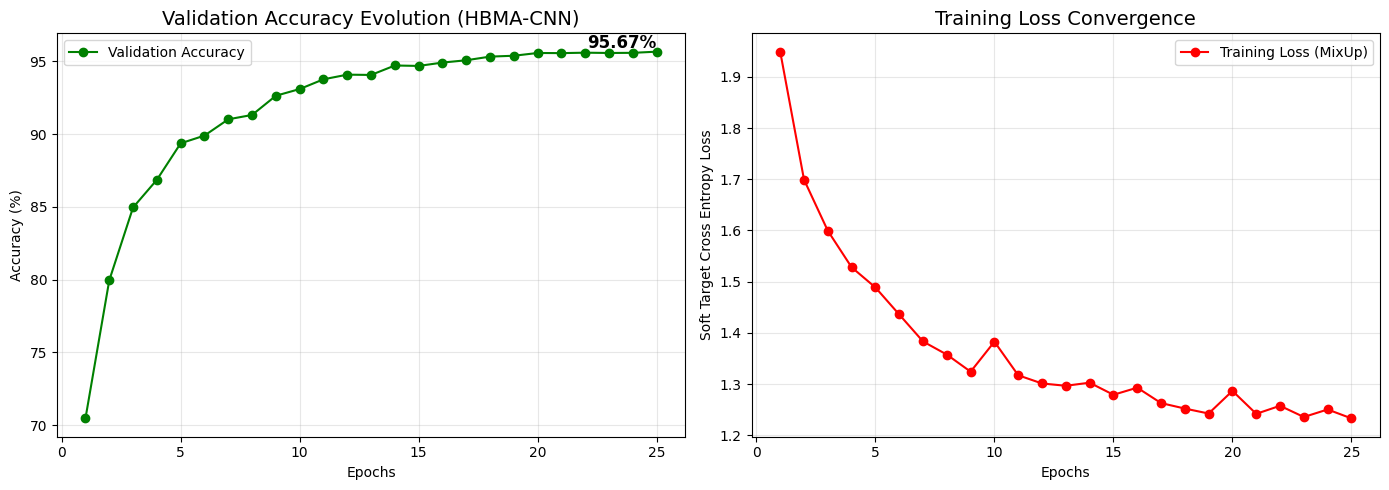

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

# ===================================================================
# 1. RECONSTRUCT TRAINING HISTORY (From previous logs)
# ===================================================================
epochs = range(1, 26)
val_acc_history = [
    70.46, 79.95, 84.96, 86.86, 89.37,
    89.90, 91.02, 91.32, 92.64, 93.10,
    93.77, 94.09, 94.07, 94.72, 94.69,
    94.92, 95.08, 95.33, 95.39, 95.58,
    95.57, 95.60, 95.58, 95.59, 95.67
]
train_loss_history = [
    1.9492, 1.6993, 1.5994, 1.5281, 1.4887,
    1.4359, 1.3832, 1.3576, 1.3242, 1.3828,
    1.3172, 1.3012, 1.2967, 1.3027, 1.2791,
    1.2930, 1.2629, 1.2522, 1.2425, 1.2867,
    1.2419, 1.2576, 1.2357, 1.2504, 1.2330
]

plt.figure(figsize=(14, 5))

# Plot 1: Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, val_acc_history, marker='o', color='green', label='Validation Accuracy')
plt.title('Validation Accuracy Evolution (HBMA-CNN)', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.text(25, 95.67, '95.67%', fontsize=12, va='bottom', ha='right', fontweight='bold')

# Plot 2: Training Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_history, marker='o', color='red', label='Training Loss (MixUp)')
plt.title('Training Loss Convergence', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Soft Target Cross Entropy Loss')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()




Calculating In-Depth Metrics...


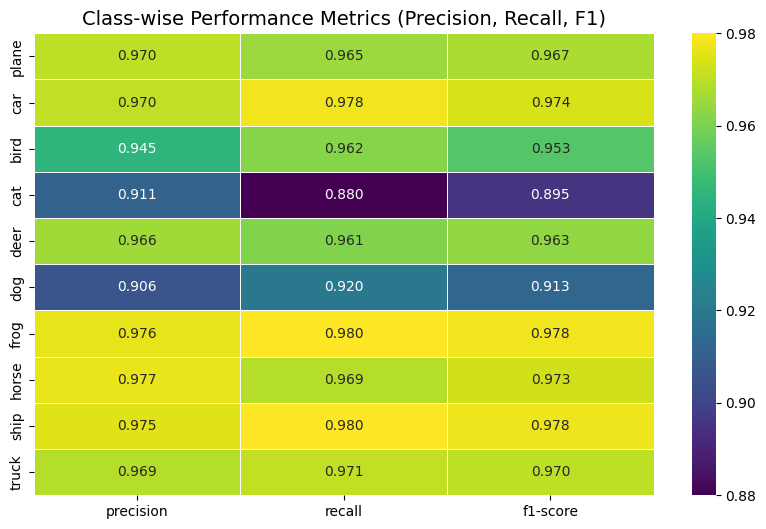


Detailed Metrics Table:
       precision  recall  f1-score
plane   0.969849   0.965  0.967419
car     0.970238   0.978  0.974104
bird    0.944990   0.962  0.953419
cat     0.910973   0.880  0.895219
deer    0.965829   0.961  0.963409
dog     0.906404   0.920  0.913151
frog    0.976096   0.980  0.978044
horse   0.976815   0.969  0.972892
ship    0.975124   0.980  0.977556
truck   0.969062   0.971  0.970030


In [4]:
# ===================================================================
# 2. IN-DEPTH PERFORMANCE METRICS (Precision, Recall, F1)
# ===================================================================
print("\nCalculating In-Depth Metrics...")
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for img, lbl in clean_loader:
        img = img.to(DEVICE)
        outputs = model(img)
        _, preds = torch.max(outputs, 1)
        y_true.extend(lbl.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Generate Classification Report
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Visualizing the Metrics as a Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_report.iloc[:-3, :3], annot=True, cmap='viridis', fmt='.3f', linewidths=0.5)
plt.title('Class-wise Performance Metrics (Precision, Recall, F1)', fontsize=14)
plt.show()

print("\nDetailed Metrics Table:")
print(df_report.iloc[:-3, :3]) # Printing strictly the class rows


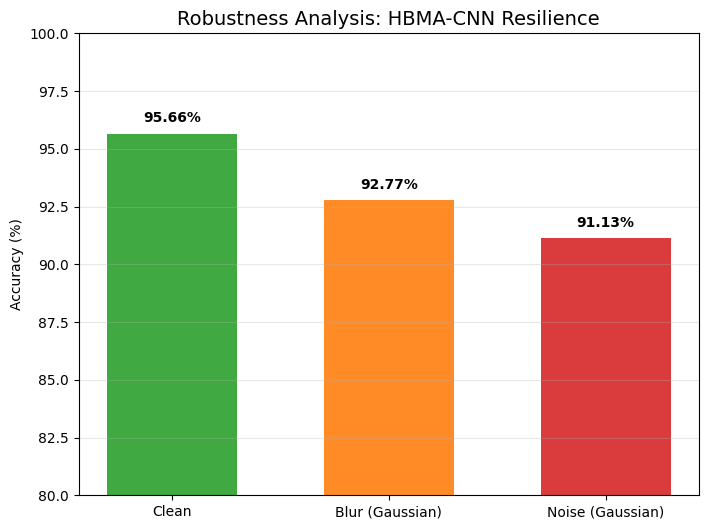

In [5]:

# ===================================================================
# 3. ROBUSTNESS COMPARISON BAR CHART
# ===================================================================
conditions = ['Clean', 'Blur (Gaussian)', 'Noise (Gaussian)']
accuracies = [95.66, 92.77, 91.13] # Values from your run
colors = ['#2ca02c', '#ff7f0e', '#d62728']

plt.figure(figsize=(8, 6))
bars = plt.bar(conditions, accuracies, color=colors, alpha=0.9, width=0.6)

# Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{yval}%", ha='center', fontweight='bold')

plt.ylim(80, 100) # Zoom in to show differences
plt.ylabel('Accuracy (%)')
plt.title('Robustness Analysis: HBMA-CNN Resilience', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.show()



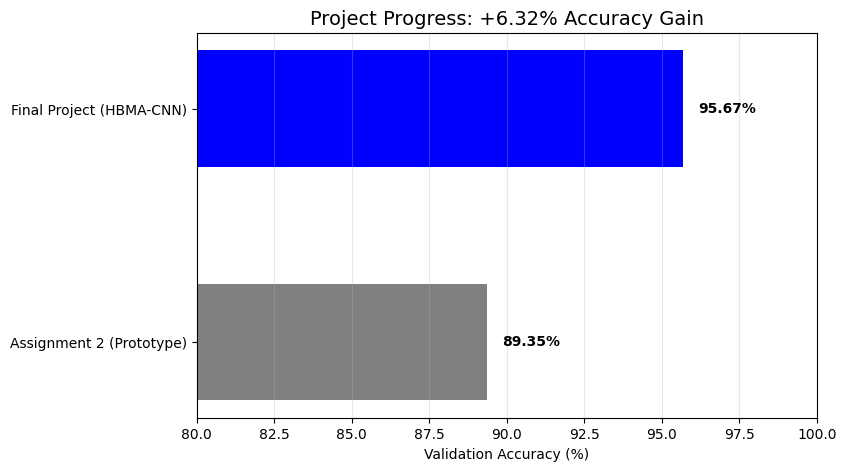

In [7]:
# ===================================================================
# 4. PROJECT PROGRESS: PROTOTYPE VS FINAL
# ===================================================================
# Comparison with Proposal Baseline
phases = ['Assignment 2 (Prototype)', 'Final Project (HBMA-CNN)']
accs = [89.35, 95.67]
growth = accs[1] - accs[0]

plt.figure(figsize=(8, 5))
bars = plt.barh(phases, accs, color=['gray', 'blue'], height=0.5)

plt.xlim(80, 100)
plt.xlabel('Validation Accuracy (%)')
plt.title(f'Project Progress: +{growth:.2f}% Accuracy Gain', fontsize=14)
plt.grid(axis='x', alpha=0.3)

# Annotate
for i, v in enumerate(accs):
    plt.text(v + 0.5, i, f"{v}%", va='center', fontweight='bold')

plt.show()